In [3]:
!pip install -r requirements.txt

  Using cached altair-5.3.0-py3-none-any.whl.metadata (9.2 kB)
  Using cached anyio-4.4.0-py3-none-any.whl.metadata (4.6 kB)
  Using cached asttokens-2.4.1-py2.py3-none-any.whl.metadata (5.2 kB)
  Using cached attrs-23.2.0-py3-none-any.whl.metadata (9.5 kB)
  Using cached aws_cdk_lib-2.144.0-py3-none-any.whl.metadata (59 kB)
  Using cached aws_cdk.asset_awscli_v1-2.2.202-py3-none-any.whl.metadata (1.1 kB)
  Using cached aws_cdk.asset_kubectl_v20-2.1.2-py3-none-any.whl.metadata (1.2 kB)
  Using cached aws_cdk.asset_node_proxy_agent_v6-2.0.3-py3-none-any.whl.metadata (1.1 kB)
  Using cached aws_psycopg2-1.3.8-py3-none-any.whl.metadata (2.1 kB)
  Using cached boto3-1.34.120-py3-none-any.whl.metadata (6.6 kB)
  Using cached botocore-1.34.120-py3-none-any.whl.metadata (5.7 kB)
  Using cached cachetools-5.3.3-py3-none-any.whl.metadata (5.3 kB)
  Using cached cattrs-23.2.3-py3-none-any.whl.metadata (10 kB)
  Using cached certifi-2024.6.2-py3-none-any.whl.metadata (2.2 kB)
  Using cached chars

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import os
import glob
from datetime import datetime
import time
import cv2
import pandas as pd

import tensorflow as tf
print(tf.__version__)

from keras.applications import EfficientNetB0
from keras.models import Model, Sequential
from keras import layers
from keras import callbacks
#from keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D, BatchNormalization
#from keras.optimizers import Adam, RMSprop

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

import funcs as f

2.16.2


In [5]:
#from keras.callbacks import EarlyStopping
class CustomStopper(callbacks.EarlyStopping):
    def __init__(self, monitor='val_loss',
             patience=5, verbose=0, mode='auto', start_epoch = 10, restore_best_weights=True): # add argument for starting epoch
        super(CustomStopper, self).__init__()
        self.start_epoch = start_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch > self.start_epoch:
            super().on_epoch_end(epoch, logs)

In [33]:
SIZE = 254 #Size of the images this model will deal with
IMDIM = 3
IMG_SIZE = (SIZE, SIZE)            # Define the image size
INPUT_SHAPE = (*IMG_SIZE, IMDIM)       # Define the input_shape

Filters = 16
BATCH_SIZE = 128
EPOCHS = 100
TEST_SIZE = 0.3   # Validation/Train split ratio

RAND_SEED  = 42 # The answer to the ultimate question of life, the universe, and everything

In [7]:
path = './branded/'
#os.system(f"aws s3 cp {'s3://open-logo-s3/branded/'} {path} --recursive")  

download: s3://open-logo-s3/branded/1800/ordered_1552_im.jpg203.jpg to branded/1800/ordered_1552_im.jpg203.jpg
download: s3://open-logo-s3/branded/1800/ordered_1553_im.jpg202.jpg to branded/1800/ordered_1553_im.jpg202.jpg
download: s3://open-logo-s3/branded/amstel_light/ordered_1584_ordered_2987_im.jpg4916.jpg to branded/amstel_light/ordered_1584_ordered_2987_im.jpg4916.jpg
download: s3://open-logo-s3/branded/3_musketeers/ordered_131_ordered_197_im.jpg6013.jpg to branded/3_musketeers/ordered_131_ordered_197_im.jpg6013.jpg
download: s3://open-logo-s3/branded/100_grand/ordered_1106_ordered_1885_ordered_2321_im.jpg7345.jpg to branded/100_grand/ordered_1106_ordered_1885_ordered_2321_im.jpg7345.jpg
download: s3://open-logo-s3/branded/airheads/ordered_623_ordered_585_im.jpg1566.jpg to branded/airheads/ordered_623_ordered_585_im.jpg1566.jpg
download: s3://open-logo-s3/branded/absopure/ordered_823_ordered_1611_im.jpg8700.jpg to branded/absopure/ordered_823_ordered_1611_im.jpg8700.jpg
download:

0

#### Read the file names and labeles

In [8]:
# this list holds all the image filename
boxes_file_paths = []
labels = []

# reads paths for each image and stores it in the array, also stores the label in a separate array
for path_tuple in os.walk(path):
    for file in path_tuple[2]:
        if file.endswith(".jpg"):
            boxes_file_paths.append(os.path.join(path_tuple[0], file))
            labels.append(path_tuple[0].split('/')[-1])

#### Prepare a dataframe of filenames and labels

In [9]:
# Convert labels to dataframe
lbl_df = pd.DataFrame(labels, columns=['label'])

# Get a new data frame with the counts of each lable
counts = lbl_df.groupby('label').value_counts().sort_values(ascending=False).to_frame()

# assign a numeric value for each label
counts['idx'] = range(len(counts))
counts['lbl'] = counts.index

# Associate uniqe numeric index with the brand and, consequently, the file
lbl_df['idx'] = lbl_df['label'].apply(lambda x: counts['idx'].loc[x])

# Add the path to the df
lbl_df['file_path'] = boxes_file_paths

# Shuffle the dataframe
lbl_df = lbl_df.sample(frac=1).reset_index(drop=True)
lbl_df

,label,idx,file_path
0,dunkin,30,./branded/dunkin/ordered_1577_im.jpg235.jpg
1,heineken,2,./branded/heineken/im.jpg3008.jpg
2,zz_unbranded,0,./branded/zz_unbranded/ordered_23_ordered_414_...
3,corona,1,./branded/corona/ordered_850_im.jpg6947.jpg
4,corona,1,./branded/corona/im.jpg110.jpg
...,...,...,...
5277,heineken,2,./branded/heineken/im.jpg9477.jpg
5278,heineken,2,./branded/heineken/im.jpg1053.jpg
5279,zz_unbranded,0,./branded/zz_unbranded/ordered_1011_ordered_18...
5280,zz_unbranded,0,./branded/zz_unbranded/ordered_1150_ordered_35...


In [10]:
# Set the number of categories
num_classes = len(counts)

#### Read the files/labels and convert them into the right shape

In [11]:
# Make an array of the images
X = []
for file_path in lbl_df['file_path']:
    # Read the image
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)

    #Resize the image so that the smaller side is the right size
    h, w = img.shape[:2]
    if h > w:
        width = SIZE
        dim = (width, int(SIZE* h / w)) 
    else:
        height = SIZE
        dim = (int(SIZE* w/h), height)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

    # Crop the image to a square of the target size
    h, w = img.shape[:2]
    if h > w:
        img = img[(h-w)//2:(h-w)//2 + w, :, :]
    else:
        img = img[:, (w-h)//2:(w-h)//2 + h, :]

    X.append(img)
X = np.array(X)
X.shape

# Get np array of labeles
y_dense = np.array(lbl_df['idx'])


y = to_categorical(y_dense, num_classes=num_classes)
y.shape

(5282, 224)

#### Read the labels

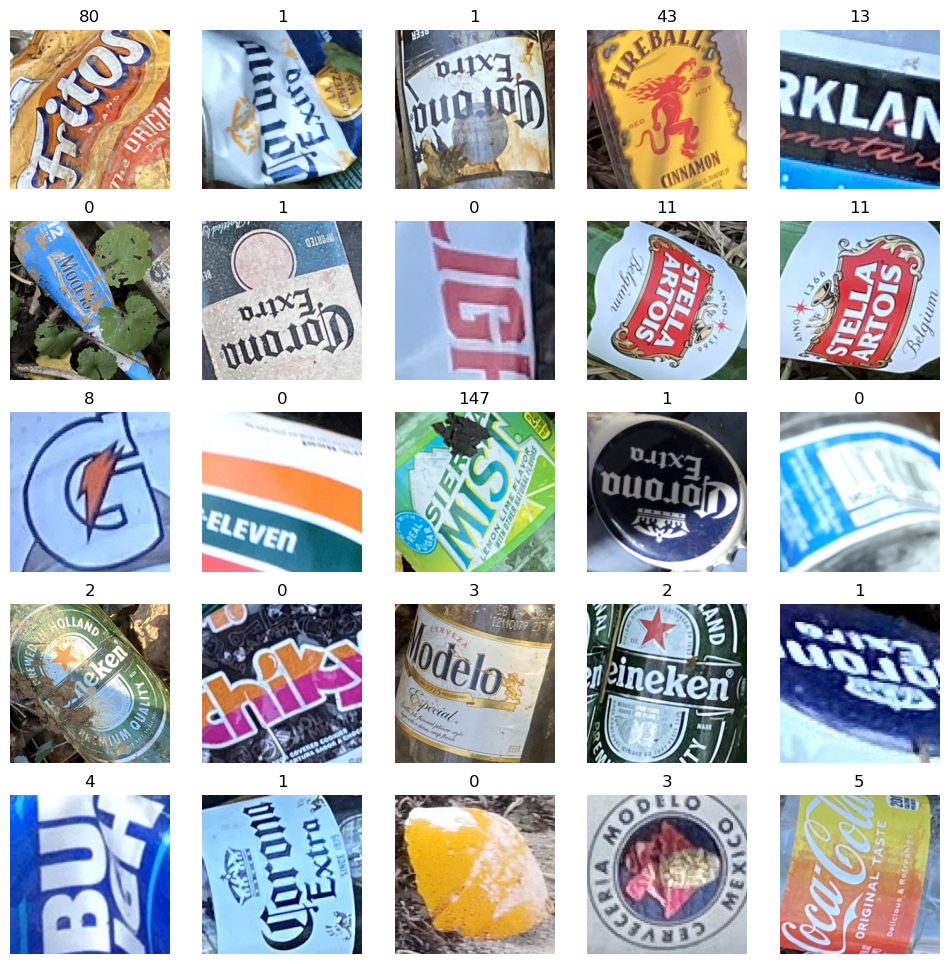

In [12]:
# Visualize random 25 images to make sure it makes sense
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(12,12))

for i, j in [(i,j) for i in np.arange(5) for j in np.arange(5)]:
    idx = np.random.choice(np.arange(len(y)))
    axs[i,j].imshow(cv2.cvtColor(X[idx], cv2.COLOR_BGR2RGB))
    axs[i,j].set_title(y_dense[idx])
    axs[i,j].axis('off')

plt.show()

# Make sure all images are square, undistorted, labels make sense

In [13]:
def build_model(num_classes):
  
    img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=1),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",)

    inputs = layers.Input(shape=INPUT_SHAPE)
    x = img_augmentation(inputs)
    EffNet_model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    EffNet_model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(EffNet_model.output)
    x = layers.BatchNormalization(name="batch_norm")(x)
    x = layers.Dense(1024, activation="relu", name="NN1")(x)
    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

early_stopping = CustomStopper()

In [34]:
from sklearn.model_selection import train_test_split

# Get the names of the files that will be used for both thresholded and non-thresholded images
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

# Create a TensorFlow Dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

#f.save_model_results(model, model_dir, X_val_names, 0.0005, y_true, y_pred, thresholds, history, result_dir, f'B0224_cust_aug')

In [35]:
#Define the model
model = build_model(num_classes)

In [ ]:
# Train the model with the early stopping callback
print("Training model...")
start_time = time.time()
history = model.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_data, verbose = 2, callbacks = [early_stopping])
end_time = time.time()
print(f"Training took {end_time - start_time:.2f} seconds")

Training model...
Epoch 1/100


2024-06-30 03:21:27.818470: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{} for conv (f32[128,96,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,96,127,127]{3,2,1,0}, f32[96,1,3,3]{3,2,1,0}), window={size=3x3 stride=2x2 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=96, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-06-30 03:21:28.043453: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.225056726s
Trying algorithm eng4{} for conv (f32[128,96,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,96,127,127]{3,2,1,0}, f32[96,1,3,3]{3,2,1,0}), window={size=3x3 stride=2x2 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=96, custom_call_target="__cudnn$convForward", backend_config={"operation_

In [29]:
# Save results
p = os.getcwd()
model_dir = os.path.join(p, 'B0_custaug_model', 'B0_custaug_model.keras')
model.save(model_dir)

result_dir = os.path.join(p, 'B0_custaug_results')



50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step


In [23]:
from sklearn.metrics import f1_score, accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, PrecisionRecallDisplay
import seaborn as sns

y_true = np.argmax(y_val, axis=1)
y_pred = model.predict(X_val)

y_pred_dense = np.argmax(y_pred, axis=1)
#f1 = f1_score(y_true, y_pred_dense, average='weighted')
accuracy = accuracy_score(y_true, y_pred_dense)
#recall = recall_score(y_true, y_pred_dense)

convergence = history.history['loss'][-1]

#Plot confusion matrics
cm = confusion_matrix(y_true, y_pred_dense)
sns.heatmap(cm, fmt='', cmap='Reds')

<Axes: >

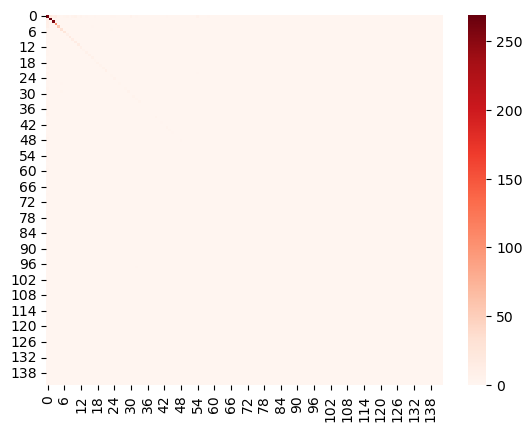

In [27]:
accuracy

0.7457413249211357

In [32]:
convergence

0.10727714002132416